## Veeresh  22m0041

## Import libraries

In [1]:
import tensorflow as tf
# You may not be able to install tensorflow using conda install inside pytmatgen.
# use pip install tensorflow

from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error

import pymatgen.core as pymat
import mendeleev as mendel
import pandas as pd
import numpy as np

import sys
import os
sys.path.insert(0, '../src/')

%matplotlib inline
import matplotlib.pyplot as plt

### 1. Getting a dataset

In [2]:
fcc_elements = ["Ag", "Al", "Au", "Cu", "Ir", "Ni", "Pb", "Pd", "Pt", "Rh", "Th", "Yb"]
bcc_elements = ["Ba", "Cr", "Eu", "Fe", "Li", "Mn", "Mo", "Na", "Nb", "Ta", "V", "W" ]
hcp_elements = ["Be", "Ca", "Cd", "Co", "Dy", "Er", "Gd", "Hf", "Ho", "Lu", "Mg", "Re", 
                "Sc", "Tb", "Ti", "Tl", "Tm", "Y", "Zn"]

elements = fcc_elements + bcc_elements + hcp_elements

querable_mendeleev = ["atomic_number", "atomic_volume", "boiling_point",
                      "en_ghosh",  "evaporation_heat", "heat_of_formation",
                     "lattice_constant", "specific_heat"]

# en_ghosh is Ghosh's scale of electronegativity. See this: https://doi.org/10.1142/S0219633605001556
# There are many such scale.

querable_pymatgen = ["atomic_mass", "atomic_radius", "electrical_resistivity",
                     "molar_volume", "bulk_modulus", "youngs_modulus",
                     "average_ionic_radius", "density_of_solid",
                     "coefficient_of_linear_thermal_expansion"]

querable_values = querable_mendeleev + querable_pymatgen

# Note that in this examples, two different APIs are used and two different sets of features have been collected.
# These features have been collated in a single set of queable values.
#np.shape(elements)

##### Querying the database

In [3]:
all_values = [] # Values for Attributes
all_labels = [] # Values for Young's Modulus (Property to be estimated)

# This neural network will produce a virtual function that will give Young's modulus E
#E = E(values)
#E = E(atomic number, atomic mass, boiling point......)

for item in elements:
    element_values = []
    
    # This section queries Mendeleev
    element_object = mendel.element(item)
    for i in querable_mendeleev:    
        element_values.append(getattr(element_object,i))

    # This section queries Pymatgen
    element_object = pymat.Element(item)    
    for i in querable_pymatgen:
        element_values.append(getattr(element_object,i))
        
    all_values.append(element_values) # All lists are appended to another list, creating a list of lists
    
# Pandas Dataframe
df = pd.DataFrame(all_values, columns=querable_values)


# The labels (values for Young's modulus) are stored separately for clarity (We drop the column later)

df.to_csv(os.path.expanduser('element_data.csv'), index=False, compression=None) # this line saves the data we collected into a .csv file into your home directory

all_labels = df['youngs_modulus'].tolist()

df = df.drop(['youngs_modulus'], axis=1)

#df.head(n=10) # With this line you can see the first ten entries of our database
df

,atomic_number,atomic_volume,boiling_point,en_ghosh,evaporation_heat,heat_of_formation,lattice_constant,specific_heat,atomic_mass,atomic_radius,electrical_resistivity,molar_volume,bulk_modulus,average_ionic_radius,density_of_solid,coefficient_of_linear_thermal_expansion
0,47,10.30,2435.15,0.147217,254.1,284.90,4.09,0.235,107.868200,1.60,1.630000e-08,10.27,100.0,1.086667,10490.0,0.000019
1,13,10.00,2792.15,0.150078,284.1,330.90,4.05,0.897,26.981539,1.25,2.700000e-08,10.00,76.0,0.675000,2700.0,0.000023
2,79,10.20,3109.15,0.261370,340.0,368.20,4.08,0.129,196.966569,1.35,2.200000e-08,10.21,220.0,1.070000,19300.0,0.000014
3,29,7.10,2833.15,0.151172,304.6,337.40,3.61,0.385,63.546000,1.35,1.720000e-08,7.11,140.0,0.820000,8920.0,0.000017
4,77,8.54,4701.15,0.251060,604.0,669.00,3.84,0.131,192.217000,1.35,4.700000e-08,8.52,320.0,0.765000,22650.0,0.000006
5,28,6.60,3186.15,0.147207,378.6,430.10,3.52,0.444,58.693400,1.35,7.200000e-08,6.59,180.0,0.740000,8908.0,0.000013
6,82,18.30,2022.15,0.177911,177.8,195.20,4.95,0.130,207.200000,1.80,2.100000e-07,18.26,46.0,1.122500,11340.0,0.000029
7,46,8.90,3236.15,0.144028,372.4,376.60,3.89,0.246,106.420000,1.40,1.080000e-07,8.56,180.0,0.846250,12023.0,0.000012
8,78,9.10,4098.15,0.256910,470.0,565.70,3.92,0.133,195.084000,1.35,1.060000e-07,9.09,230.0,0.805000,21090.0,0.000009
9,45,8.30,3968.15,0.140838,494.0,556.00,3.80,0.243,102.905500,1.35,4.300000e-08,8.28,380.0,0.745000,12450.0,0.000008


### 2. Processing and Organizing Data

Most machine learning models are trained on a subset of all the available data, called the "training set", and the models are tested on the remainder of the available data, called the "testing set". Model performance has often been found to be enhanced when the inputs are normalized.

##### SETS

With the dataset we just created, we have 44 entries for our model. We will train with 39 cases and test on the remaining 5 elements to estimate Young's Modulus.

##### NORMALIZATION

Each one of these input data features has different units and is represented in scales with distinct orders of magnitude. Datasets that contain inputs like this need to be normalized, so that quantities with large values do not bias the neural network, forcing it tune its weights to account for the different scales of our input data. In this tutorial, we will use the Standard Score Normalization, which subtracts the mean of the feature and divide by its standard deviation.

<span style="font-size:2em;">$ \frac{X - µ}{σ} $ </span>

While our model might converge without feature normalization, the resultant model would be difficult to train and would be dependent on the choice of units used in the input.

In [5]:
#We will rewrite the arrays with the patches we made on the dataset by turning the dataframe back into a list of lists

all_values = [list(df.iloc[x]) for x in range(len(all_values))]
# all_values is a list of lists.

# read about df.iloc here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html

# SETS

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow (Normalization).
all_values = np.array(all_values, dtype = float) 
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = float)
print("Shape of Labels:", all_labels.shape)

# Uncomment the line below to shuffle the dataset (we do not do this here to ensure consistent results for every run)
#order = np.argsort(np.random.random(all_labels.shape)) # This numpy argsort returns the indexes that would be used to shuffle a list
order = np.arange(43)
all_values = all_values[order]
all_labels = all_labels[order]

# Training Set, this is a manual partition. If we do the above shuffling, there will be different training set
# for each training set.
# We have 43 elements in our dataframe i.e. numpy dataset now. Our of those, 38 are used for training.
# Training data includes actual training or 'fitting' and validation. This validation is done on-the-fly using
# some of the data from training data set. It is called validation dataset. In this examples we have 10 % data
# used for validation.
# So, training data. = actual training data + validation data

train_labels = all_labels[:38]
train_values = all_values[:38]

# Testing Set. This dataset is not seen at all by the model before it is fitted.
test_labels = all_labels[-5:]
test_values = all_values[-5:]

# This line is used for labels in the plots at the end of the tutorial - Testing Set
labeled_elements = [elements[x] for x in order[-5:]] 
elements = [elements[x] for x in order]

# NORMALIZATION

mean = np.mean(train_values, axis = 0) # mean, calculating mean for each row.
std = np.std(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

mean_all = np.mean(all_values, axis = 0) # mean, calculating mean for each row.
std_all = np.std(all_values, axis = 0) # standard deviation
all_values_normalized = (all_values - mean_all) / std_all # input scaling

print(train_values[0]) # print a sample entry from the training set
print(test_values[0]) # print a sample entry from the testing set
print(order)

Shape of Values: (43, 16)
Shape of Labels: (43,)
[-0.04080514 -0.50673999 -0.61573665 -0.48000707 -0.59640276 -0.57914974
  0.23007252 -0.34851127 -0.1169633   0.27242314 -0.74442966 -0.50761875
 -0.23457382  0.8715687   0.20497176  0.23990096]
[-1.03477644 -0.46692446  0.25397834 -0.97359468  0.30431353  0.3650567
 -0.78177941  0.11430967 -1.03412225 -0.62775766  0.23766706 -0.45697574
 -0.13693109 -0.39396025 -0.84271597 -0.55854493]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


### 3. Defining the Model, Training, Testing and Predictions

For learning rate 0.001, epochs 20000 and other default setup, run the model for RMSProp, Adam and Gradient Descent and compare the loss vs. epochs.

#### RMSProp Optimiser

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


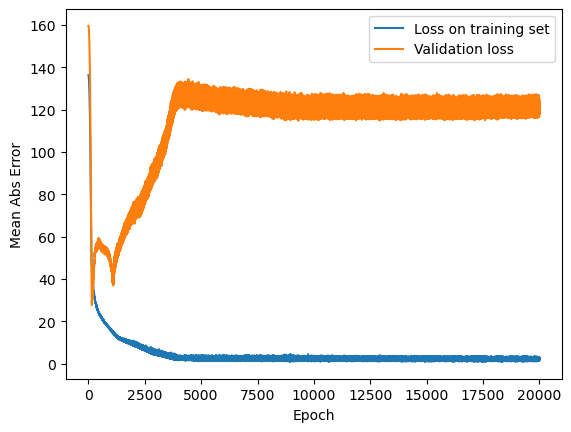

In [5]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0) # initialization of seed will always produce same result.
bias_init = initializers.Zeros()

model = Sequential() # one input layer and one output layer
# https://keras.io/guides/sequential_model/

model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS

# CHOOSING THE OPTIMIZER

optimizer = optimizers.RMSprop(learning_rate=my_learning_rate,decay=my_decay_rate) # RMSProp. Initial learning rate has been set to 0.001
# optimizer = optimizers.Adam(0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD
#
# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
# mae is Mean Absolute Error
# Read more about regression losses: https://keras.io/api/losses/regression_losses/

model.summary() # this will show a chart of the 'architecture' of the model i.e. arrangement of layers etc.

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number
# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])

# Validation split is the 10 % of training data which will be used for on-the-fly 'verification' of fit.

# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 3ms/step


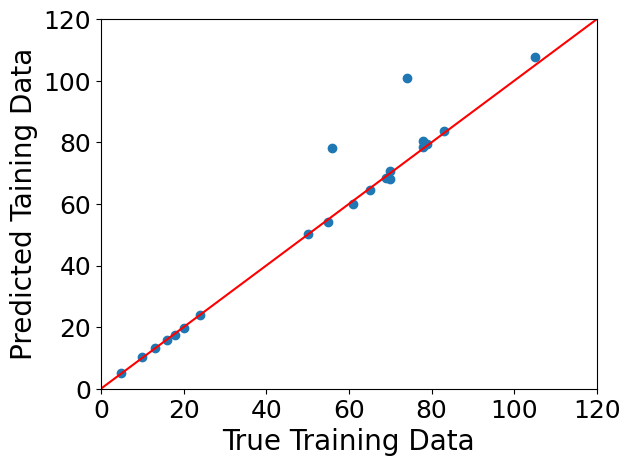

In [12]:
# Check the predictions of training data by the model
train_labels_predict=model.predict(train_values)
#
plt.scatter(train_labels,train_labels_predict)
plt.ylabel('Predicted Taining Data',fontsize=20)
plt.xlabel('True Training Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

1/1 [==============================] - 0s 19ms/step


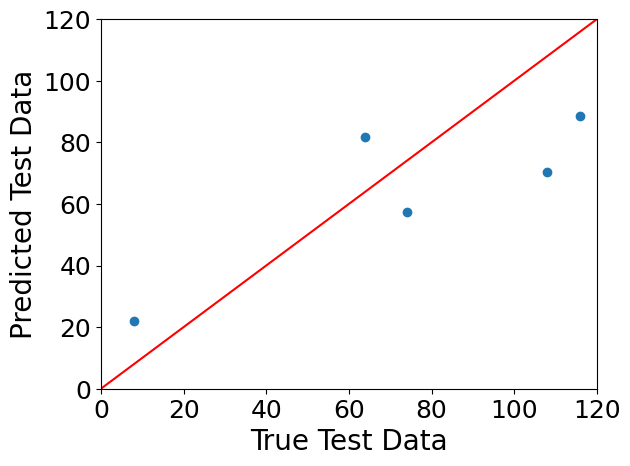

In [13]:
# Check the predictions of only test data by the model
test_labels_predict=model.predict(test_values)
#np.shape(test_labels_predict)
#np.shape(test_labels)
# Plot the predictions of only test data by the model
plt.scatter(test_labels,test_labels_predict)
plt.ylabel('Predicted Test Data',fontsize=20)
plt.xlabel('True Test Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

#### Adam Optimiser

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


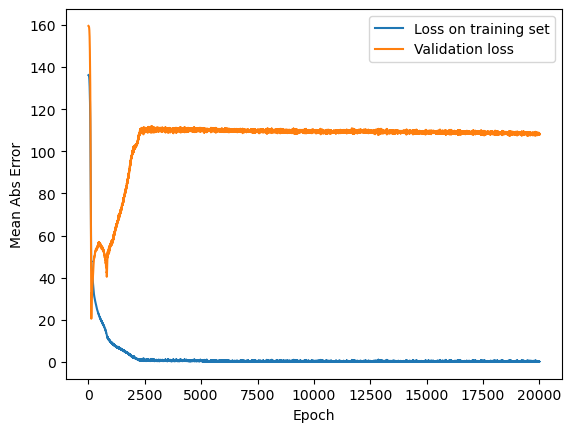

In [6]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

### Predictions by ADAM optimizer

2/2 [==============================] - 0s 0s/step


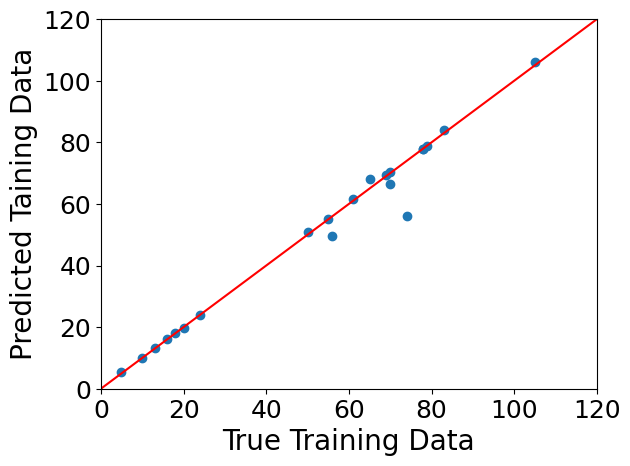

In [11]:
# Check the predictions of training data by the model
train_labels_predict=model.predict(train_values)
#
plt.scatter(train_labels,train_labels_predict)
plt.ylabel('Predicted Taining Data',fontsize=20)
plt.xlabel('True Training Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

1/1 [==============================] - 0s 19ms/step


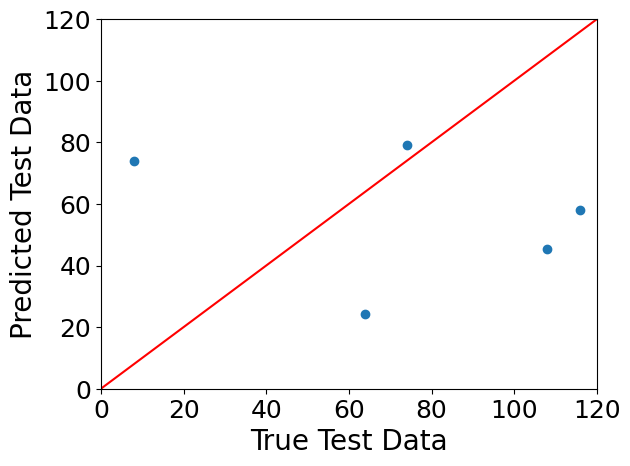

In [12]:
# Check the predictions of only test data by the model
test_labels_predict=model.predict(test_values)
#np.shape(test_labels_predict)
#np.shape(test_labels)
# Plot the predictions of only test data by the model
plt.scatter(test_labels,test_labels_predict)
plt.ylabel('Predicted Test Data',fontsize=20)
plt.xlabel('True Test Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

#### Gradient Descent Optimiser

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


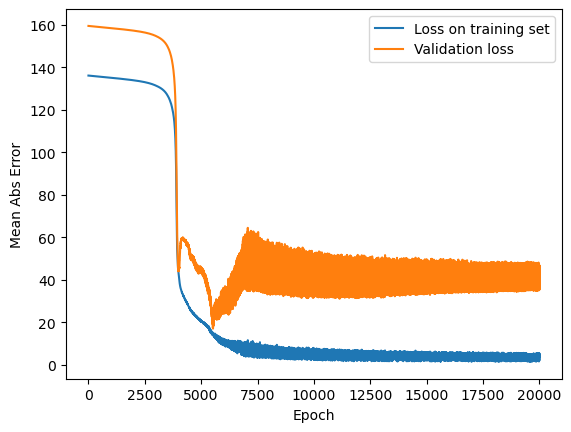

In [6]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
#model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(16, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))

#model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(16, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))

# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS

# optimizer = optimizers.RMSprop(0.001) # RMSProp
# optimizer = optimizers.Adam(0.001) # AdaM
optimizer = optimizers.SGD(learning_rate=my_learning_rate,decay=my_decay_rate) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number
        
# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

### Predictions by GD

2/2 [==============================] - 0s 18ms/step


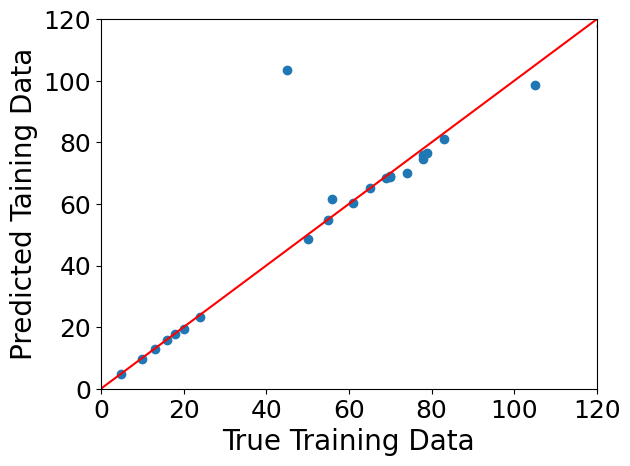

In [7]:
# Check the predictions of training data by the model
train_labels_predict=model.predict(train_values)
#
plt.scatter(train_labels,train_labels_predict)
plt.ylabel('Predicted Taining Data',fontsize=20)
plt.xlabel('True Training Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

1/1 [==============================] - 0s 47ms/step


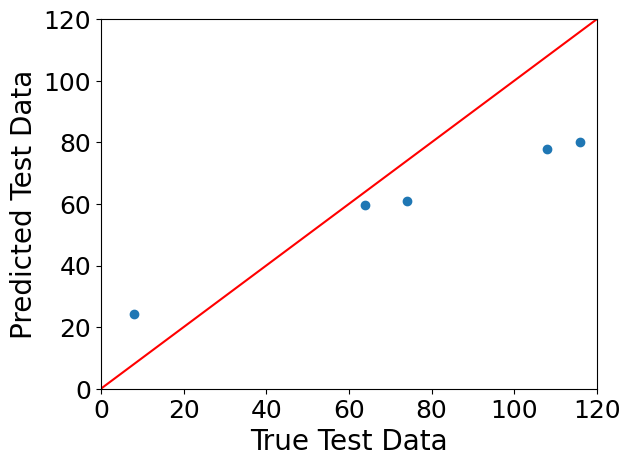

In [8]:
# Check the predictions of only test data by the model
test_labels_predict=model.predict(test_values)
#np.shape(test_labels_predict)
#np.shape(test_labels)
# Plot the predictions of only test data by the model
plt.scatter(test_labels,test_labels_predict)
plt.ylabel('Predicted Test Data',fontsize=20)
plt.xlabel('True Test Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

The training loss and validation loss for the RMSprop algorithm, respectively, are 2.61 and 123.80. The model is overfitting to the training data because the validation loss is significantly greater than the training loss. This indicates that the model does not adapt well to brand-new, unforeseen data. The model design may be too complicated, which can lead to overfitting, as one potential explanation for this. Another factor that could lead to overfitting is a sample that is too tiny or noisy. In general, excellent adaptation performance should be indicated by a validation loss that is less than the training loss.

The training loss and validation loss for the Adam algorithm, respectively, are 0.28 and 107.96. Although compared to the RMSprop optimizer, the validation loss is still greater than the training loss. This indicates that the model may be more successful than RMSprop at generalizing to novel data. Adam's ability to adjust the learning rate for each parameter based on the historical first and second moments of the gradients may be one explanation for this, as it can result in a quicker convergence and improved performance when compared to RMSprop. The validation loss' exact value, however, is still quite high, suggesting that the model may not be operating as well as it could.

The training loss and validation loss for the Gradient Descent algorithm are 3.79 and 36.69, respectively. Compared to the other two optimizers, the difference between the validation loss and the training loss is comparatively modest, suggesting that the model may not be overfitting the training data as much. The validation loss' exact value, however, is still quite high, suggesting that the model may not be operating as well as it could. Furthermore, the Gradient Descent optimizer employs a comparatively low learning rate in comparison to the other two optimizers, which may result in delayed convergence and poorer accuracy.


## 2. 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


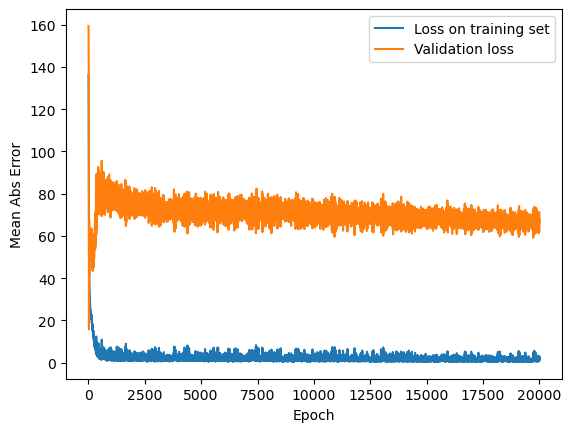

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


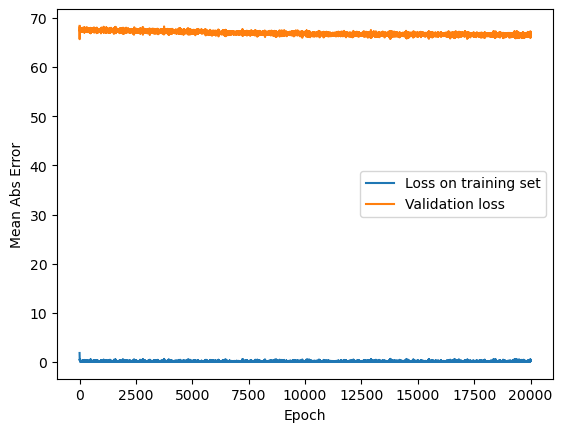

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


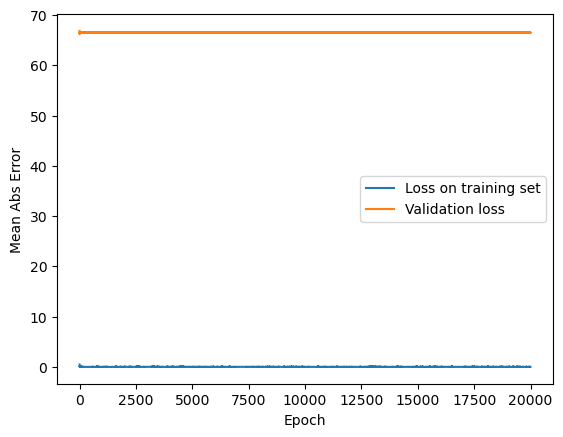

In [9]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
my_learning_rate = np.array([0.01,0.001,0.0001])

for it in my_learning_rate:
    EPOCHS = 20000 # Number of EPOCHS
    my_decay_rate = it / EPOCHS
    # optimizer = optimizers.RMSprop(0.001) # RMSProp
    optimizer = optimizers.Adam(learning_rate=it,decay=my_decay_rate)#0.001) # AdaM
    # optimizer = optimizers.SGD(0.001) # SGD
    # This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    model.summary()
    #TRAINING
    # EPOCH REAL TIME COUNTER CLASS
    class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
        def on_epoch_end(self, epoch, logs):
            sys.stdout.flush()
            sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number
    EPOCHS = 20000 # Number of EPOCHS

    # HISTORY Object which contains how the model learned
    # Training Values (Properties), Training Labels (Known Young's Moduli) 
    history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])
    # PLOTTING HISTORY USING MATPLOTLIB
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
    plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
    plt.legend()
    plt.show()

For Learning rate = 0.01:

Training loss: 2.275096
Validation loss: 66.994095

Given the significant training loss, it is likely that the model does not accurately match the training set of data. The much greater validation loss, however, suggests that the model is also failing on data that has not yet been seen. Overfitting is a situation in which a model matches training data too closely because it is too complicated, which leads to subpar extension abilities.
Justification: Because the model weights are changed too quickly at a high learning rate of 0.01 during training, the convergence is unreliable. This could lead to an overfitting of the model to the training set, which would lead to high training loss and high validation loss.

For Learning rate = 0.001:

Training loss: 0.349745
Validation loss: 67.116203

Although the validation loss is still very high despite the training loss being lower than in the prior situation, this indicates weak adaptation performance. This indicates that the model is still somewhat overfitting, albeit less so than before.
Justification: A lower learning rate of 0.001 helps to stabilize the model training, leading to slower but more consistent updates to the weights. This may lessen the amount of overfitting, but overfitting may still happen if the learning rate is too great.

For Learning rate = 0.0001:

Training loss: 0.014580
Validation loss: 66.498611

The model appears to be performing better on both the training and validation data because both the training loss and the validation loss are considerably lower than in the prior scenarios. This shows that the model is less overfitting and is better able to apply to new data.
Justification: By further slowing weight changes with a very low learning rate of 0.0001, the model can settle more gradually and avoid overfitting. However, if the learning rate is too low, the model may settle too slowly and require more training time, possibly resulting to an unsatisfactory result.

As the learning rate declines, it can also be seen that the training loss reduces while the validation loss rises. This indicates that using a very low learning rate could lead to the model being overfit on the training data, which would have a negative impact on its success on fresh data. A high learning rate, on the other hand, might make the model agree rapidly but not necessarily to the best answer. In order to obtain the best results, it is crucial to meticulously adjust the learning rate and other hyperparameters.

## 3. 


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 128)               4224      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


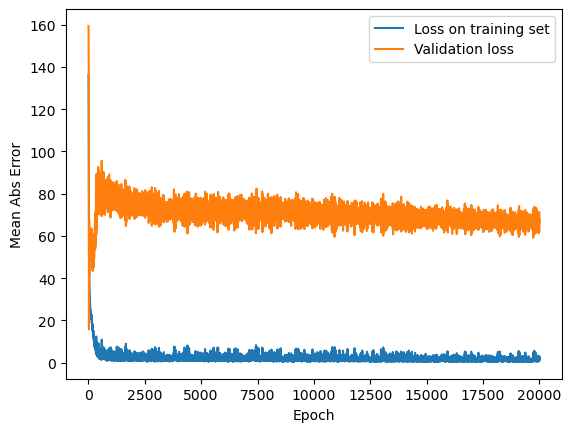

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                544       
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 128)               4224      
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


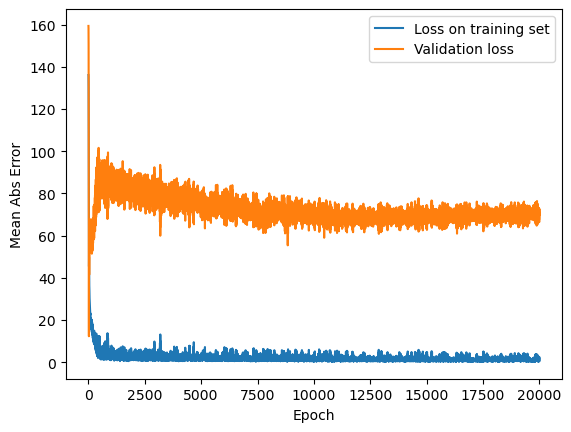

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                1088      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 128)               4224      
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________


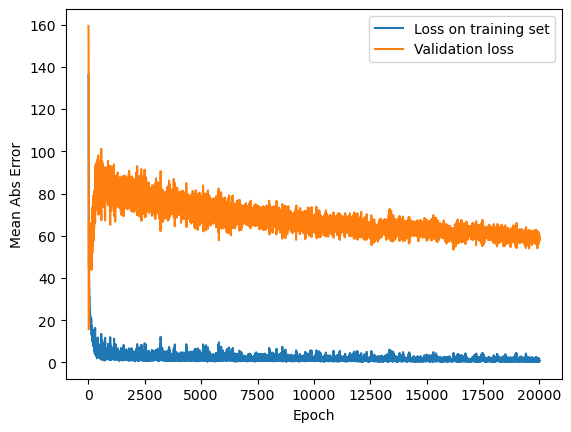

In [10]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

layers = np.array([16,32,64])
for nul in layers:
    model = Sequential()
    model.add(Dense(nul, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
    model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
    model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
    # model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
    model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))
    
    # DEFINITION OF THE OPTIMIZER
    my_learning_rate = 0.01
    EPOCHS = 20000 # Number of EPOCHS
    my_decay_rate = my_learning_rate / EPOCHS
    # optimizer = optimizers.RMSprop(0.001) # RMSProp
    optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
    # optimizer = optimizers.SGD(0.001) # SGD
    # This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    model.summary()
    #TRAINING
    # EPOCH REAL TIME COUNTER CLASS
    class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
        def on_epoch_end(self, epoch, logs):
            sys.stdout.flush()
            sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number
    EPOCHS = 20000 # Number of EPOCHS

    # HISTORY Object which contains how the model learned
    # Training Values (Properties), Training Labels (Known Young's Moduli) 
    history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])
    # PLOTTING HISTORY USING MATPLOTLIB
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
    plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
    plt.legend()
    plt.show()

Observation:

After a few thousand epochs, the training loss for the 16 units in the first layer stabilizes at about 2.3, but the validation loss stays elevated and varies around 67. This shows that the algorithm is overfitting to the training data and is unable to adapt well.

While the validation loss stays high and varies around 71 for the 32 units in the first layer, the training loss drops off quickly in the early epochs and stabilizes at around 0.7 after a few thousand. Despite the reduced training loss, this suggests that the model is also overfitting to the training data.

The training loss for the 64 units in the first layer drops quickly in the early epochs and stabilizes at about 1.4 after a few thousand epochs, while the validation loss reduces gradually and stabilizes at about 59 after about 20000 epochs. This suggests that the model can extend more effectively than the two preceding models.

Justification:

The model becomes more complicated as the number of units in the first layer rises, enabling it to recognize more intricate patterns in the data. However, if there are too many units, the model might overfit the training set and be less effective at generalizing to fresh data.


With only 16 units, the model might not be able to uncover enough intricate patterns in the data to perform well in generalization. Despite the reduced training loss, the model may be overfit to the training data in the instance of 32 units due to its excess capacity. With 64 units, the model appears to be just complex enough to pick up on trends in the data and apply well to new data.

## 4. 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 16)                272       
                                                                 
 dense_22 (Dense)            (None, 32)                544       
                                                                 
 dense_23 (Dense)            (None, 128)               4224      
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


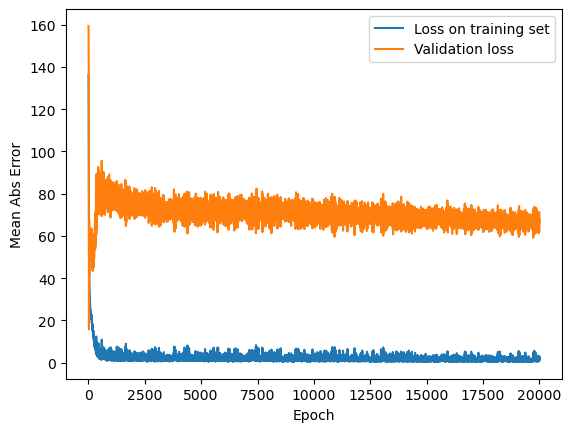

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 16)                272       
                                                                 
 dense_26 (Dense)            (None, 32)                544       
                                                                 
 dense_27 (Dense)            (None, 128)               4224      
                                                                 
 dense_28 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


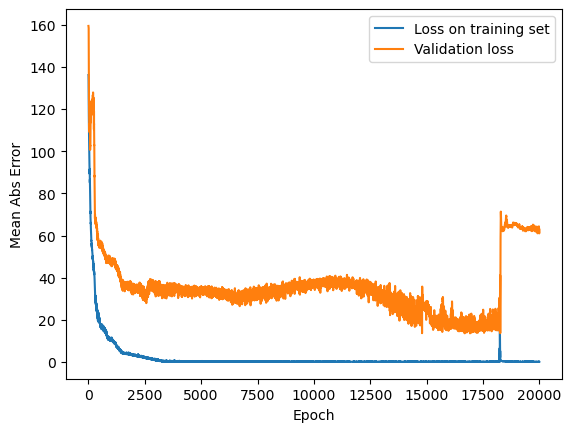

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 16)                272       
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                                 
 dense_31 (Dense)            (None, 128)               4224      
                                                                 
 dense_32 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


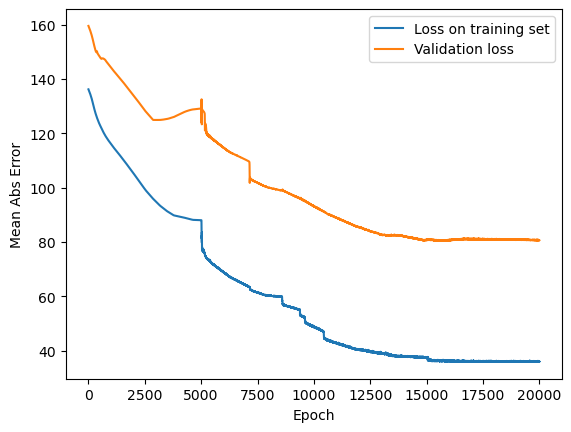

In [13]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

functions = ['relu','tanh','softmax']
for no in functions:
    model = Sequential()
    model.add(Dense(16, activation= no, input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
    model.add(Dense(32, activation= no , kernel_initializer=kernel_init, bias_initializer=bias_init))
    model.add(Dense(128, activation= no , kernel_initializer=kernel_init, bias_initializer=bias_init))
    # model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
    model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))
    
    # DEFINITION OF THE OPTIMIZER
    my_learning_rate = 0.01
    EPOCHS = 20000 # Number of EPOCHS
    my_decay_rate = my_learning_rate / EPOCHS
    # optimizer = optimizers.RMSprop(0.001) # RMSProp
    optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
    # optimizer = optimizers.SGD(0.001) # SGD
    # This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    model.summary()
    #TRAINING
    # EPOCH REAL TIME COUNTER CLASS
    class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
        def on_epoch_end(self, epoch, logs):
            sys.stdout.flush()
            sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number
    EPOCHS = 20000 # Number of EPOCHS

    # HISTORY Object which contains how the model learned
    # Training Values (Properties), Training Labels (Known Young's Moduli) 
    history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])
    # PLOTTING HISTORY USING MATPLOTLIB
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
    plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
    plt.legend()
    plt.show()

The training loss for the ReLU activation function begins at a comparatively high value of 2.27, but it rapidly drops over the course of the first few epochs and levels off at about 0.6. The validation loss declines more slowly, tapering off at about 20, after beginning at a much higher number of 66.99. Given that the validation loss is significantly greater than the training loss, it is likely that the model has overfitted the training set.

The training loss and validation loss for the tanh activation function both quickly decline within the first few epochs, achieving relatively low values of 0.08 and 62.77, respectively. The validation loss varies between 60 and 70, indicating that the model is not overfitting the data, while the training loss continues to steadily decline and levels off at around 0.04.

We see that the training loss for the softmax activation function begins at a high value and declines gradually but steadily, flattening off at about 36. The validation loss begins at a greater number and gradually declines to 80 with fewer fluctuations.

The effectiveness of a neural network depends on the activation function that is selected. ReLU is a widely used activation function that has shown to be successful in many situations, but if it is not correctly regularized, it can result in overfitting. Tanh is a symmetric activation function with an outcome that is zero-centered and limited between -1 and 1, which can improve convergence. As the output values are not bounded, Softmax may not be appropriate for regression tasks, despite being frequently used in multi-class categorization issues.


In general, we find that the tanh activation function outperformed ReLU and softmax in terms of both training and confirmation loss. This implies that tanh is the best activation function for this specific issue. It is crucial to remember that the selection of the activation function can vary depending on the particular issue and dataset, and that the best option is frequently determined through trial and error.